# Customer Churn Prediction Project

#### This machine learning project predicts whether a customer will churn or not based on their profile and subscription behavior using Mock Data. These steps include:
- Data Generation
- Exploratory Data Analysis (EDA)
- Feature Engineering
- Model Training
- Model Evaluation
- Saving & Loading the Best Model

### Importing Required Libraries

In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from imblearn.combine import SMOTEENN
import pickle
import warnings
warnings.filterwarnings('ignore')


### Generate Mock Data

In [43]:
np.random.seed(42)
n = 10000
data = pd.DataFrame({
    'CustomerID': np.arange(n),
    'Gender': np.random.choice(['Male', 'Female'], size=n),
    'SeniorCitizen': np.random.choice([0, 1], size=n),
    'Tenure': np.random.randint(1, 72, size=n),
    'MonthlyCharges': np.round(np.random.uniform(20, 120, size=n), 2),
    'Contract': np.random.choice(['Month-to-month', 'One year', 'Two year'], size=n),
    'PaymentMethod': np.random.choice(['Electronic check', 'Mailed check', 'Bank transfer', 'Credit card'], size=n),
    'Churn': np.random.choice([0, 1], size=n, p=[0.73, 0.27])
})
data['TotalCharges'] = (data['Tenure'] * data['MonthlyCharges']).round(2)

### Exploratory Data Analysis (EDA)

In this step, we explore the dataset using basic plots to identify trends and distribution patterns:

- **Gender Distribution:**   Helps us understand the ratio of Male vs Female customers.
- **Churn Count:**   Shows how many customers have churned vs retained.
- **Contract Types:**   lets see which type of contracts are more common.
- **Monthly Charges Distribution:**   Helps spot average billing amounts and outliers.

In [44]:
# Dataset shape
print("Dataset Shape:", data.shape)

Dataset Shape: (10000, 9)


In [45]:

# Data types
print("\nData Types:\n")
print(data.dtypes)



Data Types:

CustomerID          int64
Gender             object
SeniorCitizen       int64
Tenure              int32
MonthlyCharges    float64
Contract           object
PaymentMethod      object
Churn               int64
TotalCharges      float64
dtype: object


In [46]:
# Missing values
print("Missing Values in Each Column:\n")
print(data.isnull().sum())

Missing Values in Each Column:

CustomerID        0
Gender            0
SeniorCitizen     0
Tenure            0
MonthlyCharges    0
Contract          0
PaymentMethod     0
Churn             0
TotalCharges      0
dtype: int64


In [47]:
# Summary statistics
print("Statistical Summary:\n")
print(data.describe())

Statistical Summary:

        CustomerID  SeniorCitizen        Tenure  MonthlyCharges         Churn  \
count  10000.00000   10000.000000  10000.000000    10000.000000  10000.000000   
mean    4999.50000       0.499300     35.955000       70.451038      0.267000   
std     2886.89568       0.500025     20.501761       28.935692      0.442414   
min        0.00000       0.000000      1.000000       20.000000      0.000000   
25%     2499.75000       0.000000     18.000000       45.527500      0.000000   
50%     4999.50000       0.000000     36.000000       70.585000      0.000000   
75%     7499.25000       1.000000     54.000000       95.612500      1.000000   
max     9999.00000       1.000000     71.000000      120.000000      1.000000   

       TotalCharges  
count  10000.000000  
mean    2541.807390  
std     1879.645307  
min       21.200000  
25%     1035.057500  
50%     2117.135000  
75%     3717.352500  
max     8384.390000  


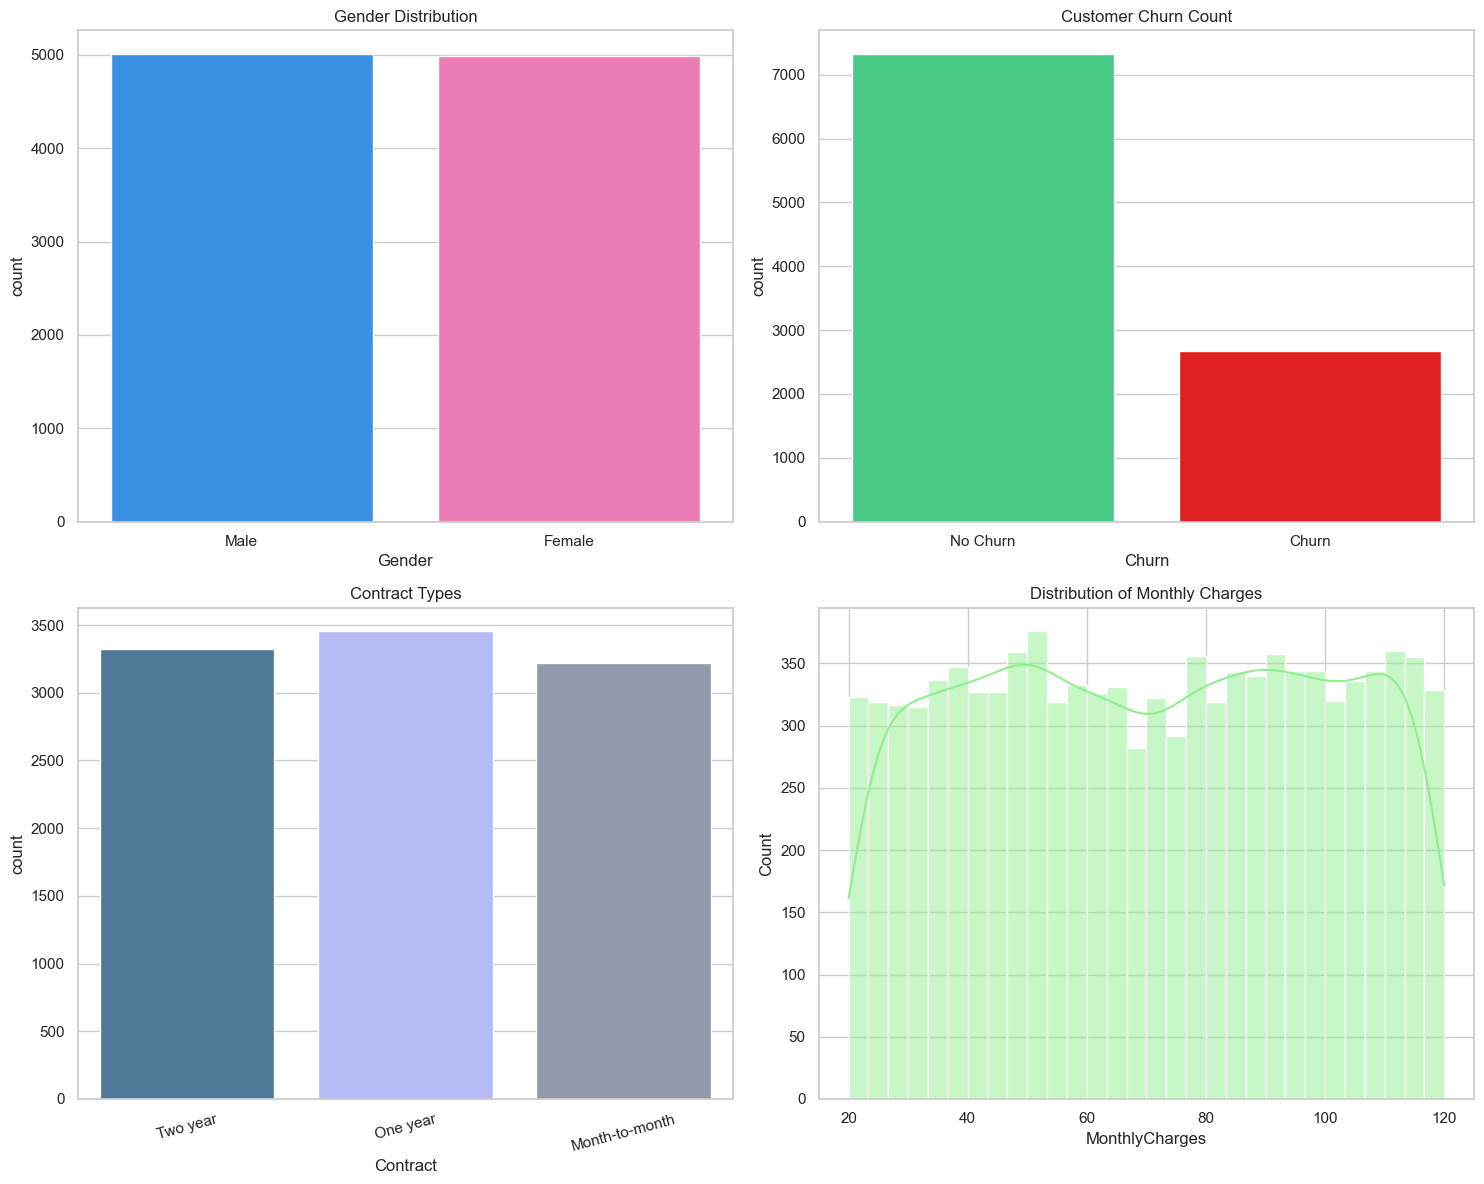

In [48]:
# Set style for plots
sns.set(style="whitegrid")
plt.figure(figsize=(15, 12))

# 1. Gender Distribution
plt.subplot(2, 2, 1)
colors = ['#1E90FF', '#FF69B4']
sns.countplot(x = 'Gender', hue = 'Gender', data = data, palette = colors, legend = False)
plt.title('Gender Distribution')

# 2. Churn Count
plt.subplot(2, 2, 2)
colors = ['#32de84', '#FF0000']
sns.countplot(x = 'Churn', hue = 'Churn', data = data, palette = colors, legend = False)
plt.title('Customer Churn Count')
plt.xticks([0, 1], ['No Churn', 'Churn'])

# 3. Contract Type Distribution
plt.subplot(2, 2, 3)
colors = ['#427aa1', '#aab2ff', '#8d99ae']
sns.countplot(x = 'Contract', hue = 'Contract', data = data, palette = colors, legend = False)
plt.title('Contract Types')
plt.xticks(rotation=15)

# 4. Monthly Charges Distribution
plt.subplot(2, 2, 4)
sns.histplot(data['MonthlyCharges'], kde = True, bins = 30, color = 'lightgreen')
plt.title('Distribution of Monthly Charges')

plt.tight_layout()
plt.show()

In [49]:
# plt.figure(figsize=(6, 4))
# sns.countplot(data=data, x='Churn')
# plt.title("Churn Distribution")
# plt.show()

# plt.figure(figsize=(8, 6))
# sns.boxplot(data=data, x='Churn', y='MonthlyCharges')
# plt.title("Monthly Charges by Churn")
# plt.show()

# plt.figure(figsize=(8, 6))
# sns.boxplot(data=data, x='Churn', y='Tenure')
# plt.title("Tenure by Churn")
# plt.show()

### Correlation Heatmap

This heatmap shows the linear relationships between numerical features.
Values range from -1 to 1:

- **1** means perfect positive correlation (when one increases, the other also increases)
- **-1** means perfect negative correlation (when one increases, the other decreases)
- **0** means no correlation

This helps us understand which features have a strong relationship with the target variable Churn.

In [50]:
# corr = data[['Tenure', 'MonthlyCharges', 'TotalCharges', 'Churn']].corr()
# plt.figure(figsize=(6, 4))
# sns.heatmap(corr, annot=True, cmap='coolwarm')
# plt.title("Correlation Matrix")
# plt.show()

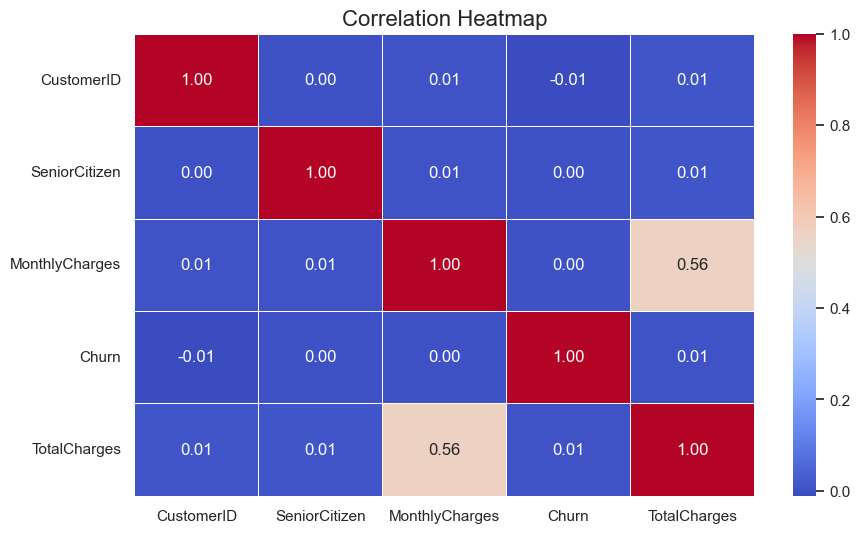

In [51]:
# Correlation Matrix
# for only numerical columns
numeric_features = data.select_dtypes(include=['int64', 'float64'])

# Compute correlation matrix
corr_matrix = numeric_features.corr()

# Plotting heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap", fontsize=16)
plt.show()

### Feature Engineering

- One-hot encode categorical columns


In [52]:
categorical_cols = ['Gender', 'Contract', 'PaymentMethod']
encoder = OneHotEncoder(drop='first', sparse_output=False)
encoded_features = encoder.fit_transform(data[categorical_cols])
encoded_df = pd.DataFrame(encoded_features, columns=encoder.get_feature_names_out(categorical_cols))
data = data.drop(columns=categorical_cols).reset_index(drop=True)
data = pd.concat([data, encoded_df], axis=1)


- Scale numeric features

In [53]:

numerical_cols = ['MonthlyCharges', 'TotalCharges', 'Tenure']
scaler = StandardScaler()
scaled_features = scaler.fit_transform(data[numerical_cols])
scaled_df = pd.DataFrame(scaled_features, columns=numerical_cols)
data[numerical_cols] = scaled_df



### Train-Test Split & Handle Class Imbalance

In [54]:
X = data.drop(['Churn', 'CustomerID'], axis=1)
Y = data['Churn']
sm = SMOTEENN()
X_resampled, y_resampled = sm.fit_resample(X, Y)
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=100)


### Train Base Models

In [55]:
# Decision Tree
model_dt = DecisionTreeClassifier(criterion="gini", random_state=100, max_depth=6, min_samples_leaf=8)
model_dt.fit(X_train, y_train)
y_pred_dt = model_dt.predict(X_test)

# Random Forest
model_rf = RandomForestClassifier(n_estimators=100, criterion="gini", random_state=100, max_depth=6, min_samples_leaf=8)
model_rf.fit(X_train, y_train)
y_pred_rf = model_rf.predict(X_test)


### Random Forest Optimization (Hyperparameter Tuning)

In [56]:
param_grid_rf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 10, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 4, 8],
    'criterion': ['gini', 'entropy']
}
rf_search = RandomizedSearchCV(RandomForestClassifier(random_state=100), param_grid_rf, cv=3, n_iter=10, scoring='accuracy', n_jobs=-1)
rf_search.fit(X_train, y_train)
best_rf_params = rf_search.best_params_
model_rf_optimized = RandomForestClassifier(**best_rf_params, random_state=100)
model_rf_optimized.fit(X_train, y_train)
y_pred_rf_optimized = model_rf_optimized.predict(X_test)

### PCA for Dimensionality Reduction

In [57]:

pca = PCA(0.9)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)
model_pca = RandomForestClassifier(n_estimators=100, criterion='gini', random_state=100, max_depth=6, min_samples_leaf=8)
model_pca.fit(X_train_pca, y_train)
y_pred_pca = model_pca.predict(X_test_pca)


### Evaluation & Reporting

In [58]:
print("📊 Model Performance Report")
print("Decision Tree Accuracy:", model_dt.score(X_test, y_test))
print("Random Forest Accuracy:", model_rf.score(X_test, y_test))
print("Optimized Random Forest Accuracy:", model_rf_optimized.score(X_test, y_test))
print("PCA Applied Random Forest Accuracy:", model_pca.score(X_test_pca, y_test))


📊 Model Performance Report
Decision Tree Accuracy: 0.5918173168411037
Random Forest Accuracy: 0.621313035204567
Optimized Random Forest Accuracy: 0.8744053282588011
PCA Applied Random Forest Accuracy: 0.6755470980019029


In [59]:

print("Confusion Matrix (Optimized RF):")
print(confusion_matrix(y_test, y_pred_rf_optimized))
print("\nClassification Report (Optimized RF):")
print(classification_report(y_test, y_pred_rf_optimized))


Confusion Matrix (Optimized RF):
[[391  83]
 [ 49 528]]

Classification Report (Optimized RF):
              precision    recall  f1-score   support

           0       0.89      0.82      0.86       474
           1       0.86      0.92      0.89       577

    accuracy                           0.87      1051
   macro avg       0.88      0.87      0.87      1051
weighted avg       0.88      0.87      0.87      1051



### Save and Load the Optimized Model

In [60]:
filename = 'optimized_churn_model.sav'
pickle.dump(model_rf_optimized, open(filename, 'wb'))

loaded_model = pickle.load(open(filename, 'rb'))
accuracy_loaded = loaded_model.score(X_test, y_test)
print(f"\nLoaded Model Accuracy: {accuracy_loaded}")



Loaded Model Accuracy: 0.8744053282588011
